<a href="https://colab.research.google.com/github/sarvan0506/AI/blob/Dev/Assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding ENAS network, Skip Connections and multiple receptive fields

##### Import libraries

In [0]:
import tensorflow as tf
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers, layers
from keras.models import Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dropout, Input, concatenate, Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


##### Downloading CIFAR10 dataset

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


##### Visualizing soe of the images of each class from the Dataset to get an idea

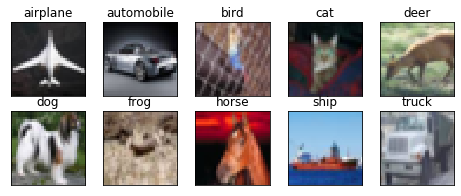

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

##### Utility function to plot model history

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

##### Utility function to calculate accuracy

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
# Building the network use keras functionla API

input_img = Input(shape=(32, 32, 3))


L1 = SeparableConv2D(16, kernel_size=(5, 5), padding ='same')(input_img) # output_channel_size - 32
L1 = BatchNormalization()(L1)
L1 = Activation('relu')(L1)

L2 = Convolution2D(32, 5, 5, border_mode='same')(L1) # output_channel_size - 32
L2 = BatchNormalization()(L2)
L2 = Activation('relu')(L2)

L3 = Convolution2D(64, 5, 5, border_mode='same')(L2) # output_channel_size - 32
L3 = BatchNormalization()(L3)
L3 = Activation('relu')(L3)

L4 = SeparableConv2D(128, kernel_size=(5, 5), padding ='same')(L3) # output_channel_size - 32
L4 = BatchNormalization()(L4)
L4 = Activation('relu')(L4)

M1 = MaxPooling2D(pool_size=(2, 2))(L4) # output_channel_size - 16
M1 = Dropout(0.2)(M1)

B1 = Convolution2D(16, 1, 1)(M1)
B1 = BatchNormalization()(B1)
B1 = Activation('relu')(B1)

L5 = SeparableConv2D(16, kernel_size=(3, 3), padding ='same')(B1) # output_channel_size - 16
L5 = BatchNormalization()(L5)
L5 = Activation('relu')(L5)

L6 = Convolution2D(32, 5, 5, border_mode='same')(L5) # output_channel_size - 16
L6 = BatchNormalization()(L6)
L6 = Activation('relu')(L6)

L7 = SeparableConv2D(64, kernel_size=(3, 3), padding ='same')(L6) # output_channel_size - 16
L7 = BatchNormalization()(L7)
L7 = Activation('relu')(L7)

L8 = SeparableConv2D(128, kernel_size=(5, 5), padding ='same')(L7) # output_channel_size - 16
L8 = BatchNormalization()(L8)
L8 = Activation('relu')(L8)

# Skip Connection 1

S1 = Lambda(lambda x: tf.space_to_depth(L4, block_size=2))(L4)
S1 = concatenate([L8, S1], axis=-1)

M2 = MaxPooling2D(pool_size=(2, 2))(S1) # output_channel_size - 8
M2 = Dropout(0.2)(M2)

B2 = Convolution2D(16, 1, 1)(M2)
B2 = BatchNormalization()(B2)
B2 = Activation('relu')(B2)

L9 = Convolution2D(16, 5, 5, border_mode='same')(B2) # output_channel_size - 8
L9 = BatchNormalization()(L9)
L9 = Activation('relu')(L9)

L10 = SeparableConv2D(32, kernel_size=(5, 5), padding ='same')(L9) # output_channel_size - 8
L10 = BatchNormalization()(L10)
L10 = Activation('relu')(L10)

L11 = Convolution2D(64, 3, 3, border_mode='same')(L10) # output_channel_size - 8
L11 = BatchNormalization()(L11)
L11 = Activation('relu')(L11)

L12 = SeparableConv2D(128, kernel_size=(5, 5))(L10) # output_channel_size - 4
L12 = BatchNormalization()(L12)
L12 = Activation('relu')(L12)

# Skip Connection 2

S2 = Lambda(lambda x: tf.space_to_depth(L8, block_size=4))(L8)
S2 = concatenate([L12, S2], axis=-1)

# Skip Connection 3

S3 = Lambda(lambda x: tf.space_to_depth(L4, block_size=8))(L4)
S3 = concatenate([S3, S2], axis=-1)

B3 = Convolution2D(10, 1, 1)(S3)

GAP = AveragePooling2D(pool_size = (4,4))(B3)
F   = Flatten()(GAP)
out = Activation('softmax')(F)

model = Model(input_img, out)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
  del sys.path[0]



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), padding="same")`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1))`


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 16)   139         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  # Remove the CWD from sys.path while we load stuff.




Epoch 1/100
390/390 [==============================] - 27s 68ms/step - loss: 1.5637 - acc: 0.4387 - val_loss: 1.6020 - val_acc: 0.4480
Epoch 2/100
390/390 [==============================] - 20s 50ms/step - loss: 1.1432 - acc: 0.5919 - val_loss: 1.5575 - val_acc: 0.4921
Epoch 3/100
390/390 [==============================] - 20s 50ms/step - loss: 0.9417 - acc: 0.6686 - val_loss: 1.1368 - val_acc: 0.6294
Epoch 4/100
390/390 [==============================] - 20s 50ms/step - loss: 0.8301 - acc: 0.7091 - val_loss: 1.3533 - val_acc: 0.5666
Epoch 5/100
390/390 [==============================] - 20s 50ms/step - loss: 0.7490 - acc: 0.7380 - val_loss: 0.9392 - val_acc: 0.6839
Epoch 6/100
390/390 [==============================] - 19s 50ms/step - loss: 0.6836 - acc: 0.7620 - val_loss: 0.9300 - val_acc: 0.6872
Epoch 7/100
390/390 [==============================] - 19s 50ms/step - loss: 0.6257 - acc: 0.7823 - val_loss: 2.2812 - val_acc: 0.4959
Epoch 8/100
390/390 [==============================] 

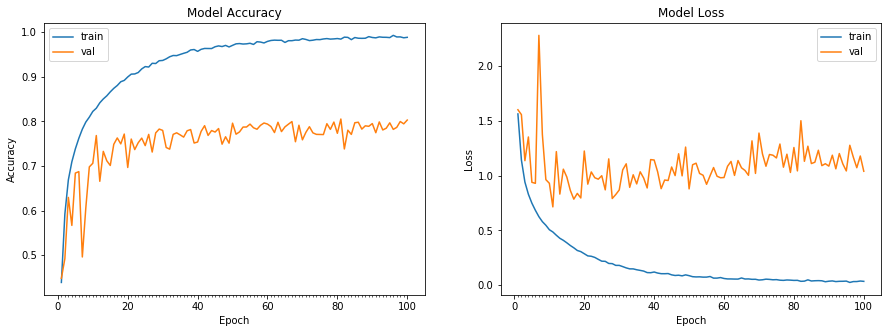

Accuracy on test data is: 80.28


In [0]:
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)  


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

#### Without any further optimization the model is able to train to an accuracy of 80.28%. Hence the implementation of functional api in keras is understood.